In [1]:
# gpu info
!nvidia-smi -L

GPU 0: NVIDIA GeForce MX450 (UUID: GPU-f8138aab-5e62-432f-3a34-fa8e2d8584cf)


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *

import sys
import os
import glob
import urllib.request
from tqdm.auto import tqdm

### Train the UNET

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision.utils import save_image

# set up device
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

# Specify parameters
BATCH_SIZE = 1
NUM_WORKERS = 0
epoch_num = 200

C:\Users\Lenovo\anaconda3\envs\dl\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 


In [19]:
# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

# load custom modules/variables
sys.path.append('./torch_modules')
from helper_funcs import TF_to_npy,eval_model
from Global_Variables import proj_yr_selected,TRAIN_SIZE,EVAL_SIZE,KERNEL_SIZE


# The base names for train_eval data
sample_path = './Sample_npy'
train_base = f'train_{proj_yr_selected[0]}_{proj_yr_selected[1]}_patch'
eval_base = f'eval_{proj_yr_selected[0]}_{proj_yr_selected[1]}_patch'

# make the sample directory
if not os.path.exists(sample_path):
    os.mkdir(sample_path)

# if there are > 95% sample data found in the folder, then skip below TF to np process
if len(glob.glob(f'{sample_path}/*')) > (TRAIN_SIZE+EVAL_SIZE)*0.95:
    print('\nSamples already there! Skip TF to Npy!')
else:
    TF_to_npy(train_base,eval_base,path=sample_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Samples already there! Skip TF to Npy!


In [5]:
#  dataloader class
class MyDataset(Dataset):
    def __init__(self,sample_base,sample_path):
        self.sample_npys = glob.glob(f'{sample_path}/{sample_base}*')

    def __len__(self):
        return len(self.sample_npys)

    def __getitem__(self, index):
        data = np.load(self.sample_npys[index],allow_pickle=True)
        return data[0],data[1]

# get train & eval loader
train_loader = DataLoader(MyDataset('train',sample_path),batch_size=BATCH_SIZE,pin_memory=True,shuffle=True,num_workers=NUM_WORKERS)
eval_loader = DataLoader(MyDataset('eval',sample_path),batch_size=BATCH_SIZE,pin_memory=True,num_workers=NUM_WORKERS)

#### Create the CNN model

In [6]:
# from torch_modules.UNET_model_aladin import UNET
# model = UNET()

# load a pretrained model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in C:\Users\Lenovo/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [7]:
# send model to GPU
m = model.to(dev)

# set optimizer and creterion
optimizer = torch.optim.Adam(m.parameters())
creterion = nn.BCELoss()

In [8]:
# load the trained modle
longest_trained_model = glob.glob('./Saved_models/progress_model*')
if len(longest_trained_model) > 0:

    # load historical training models
    longest_trained_model = sorted(longest_trained_model)[-1]
    m.load_state_dict(torch.load(longest_trained_model,map_location=torch.device(dev)))
    start_epoch = int(longest_trained_model[-7:-4])

    metrics_df = pd.read_csv('./Metrics_csv/metrics.csv',header=None)
    best_loss = metrics_df[metrics_df[1]=='eval'][2].min()
else:
    start_epoch = 0
    best_loss = 1e9
    # empty the recored folders
    files = [i for i in glob.glob('./Saved_models/*') if not "PRESERVE" in i]
    files.extend(glob.glob('./Metrics_csv/*'))
    files.extend(glob.glob('./Train_model_pred_imgs/*.jpeg'))
    for i in files:
        os.remove(i)
        print(i)

In [9]:
# Train the model
metrics = {}

for epoch in range(start_epoch,epoch_num):

  train_losses = []
  for data in tqdm(train_loader):
    #______________________Training__________________
    
    # get data, then send them to GPU
    x = torch.FloatTensor(data[0]).to(dev)
    y = torch.FloatTensor(data[1]).to(dev)

    # train the model
    score = m(x)
    loss = creterion(score,y)

    # back-propagate
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # store traning losses
    train_losses.append(loss.item())

  #______________________Evaluation____________________
  eval_loss = eval_model(m,eval_loader,creterion)

  # store metrics
  train_losses_mean = np.array(train_losses).mean()
  eval_losses_mean = np.array(eval_loss).mean()

  metrics[(epoch,'train')] = [train_losses_mean]
  metrics[(epoch,'eval')] = [eval_losses_mean]

  # write metric to disk
  with open('./Metrics_csv/metrics.csv', 'a') as f:
    f.write(f'{epoch},train,{train_losses_mean}\n')
    f.write(f'{epoch},eval,{eval_losses_mean}\n')

  #_________Inference use a random img and save to disk___________
  # load one img
  one_img_path = './Train_model_pred_imgs/one_img.npy'
  one_img = np.load(one_img_path,allow_pickle=True)
  x_img = torch.FloatTensor(one_img[0]).unsqueeze(0).to(dev)
  y_img = one_img[1]

  # passing the img to model
  pred_img = m(x_img).cpu().detach().numpy()[0,0,:,:]
  true_img = y_img.squeeze(0)

  # save true-pred img to disk
  img_save_path = './Train_model_pred_imgs'
  concat_img = np.concatenate([pred_img,true_img],1)
  save_image(torch.tensor(concat_img),f"{img_save_path}/train_pred_img_{epoch:03}.jpeg")

  #______________________Save models to disk____________________
  model_path = './Saved_models'

  # save best models
  if eval_losses_mean < best_loss:
    # update best_loss
    best_loss = eval_losses_mean
    # save model to disk
    torch.save(m.state_dict(), f'{model_path}/best_model_{epoch:03}.tar')

  # save model for every 5 eopch
  if (epoch + 1)%5 == 0:
    # save model to disk
    torch.save(m.state_dict(), f'{model_path}/progress_model_{epoch:03}.tar')

  # report the training process
  print(f"The loss of 【{epoch:03}】 is: Train:{train_losses_mean:.5f} Eval:{eval_losses_mean:.5f}")
  print()

  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【000】 is: Train:0.24273 Eval:0.25049



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【001】 is: Train:0.20570 Eval:0.44734



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【002】 is: Train:0.19880 Eval:0.27560



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【003】 is: Train:0.19462 Eval:0.32204



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【004】 is: Train:0.19258 Eval:0.29173



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【005】 is: Train:0.19016 Eval:0.24345



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【006】 is: Train:0.18908 Eval:0.30140



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【007】 is: Train:0.18801 Eval:0.35030



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【008】 is: Train:0.18706 Eval:0.25552



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【009】 is: Train:0.18621 Eval:0.25700



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【010】 is: Train:0.18506 Eval:0.32143



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【011】 is: Train:0.18413 Eval:0.28931



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【012】 is: Train:0.18372 Eval:0.24468



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【013】 is: Train:0.18302 Eval:0.32795



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【014】 is: Train:0.18211 Eval:0.25811



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【015】 is: Train:0.18170 Eval:0.29609



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【016】 is: Train:0.18080 Eval:0.26132



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【017】 is: Train:0.18036 Eval:0.27303



  0%|          | 0/7990 [00:00<?, ?it/s]

The loss of 【018】 is: Train:0.17941 Eval:0.27430



  0%|          | 0/7990 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Explore the results

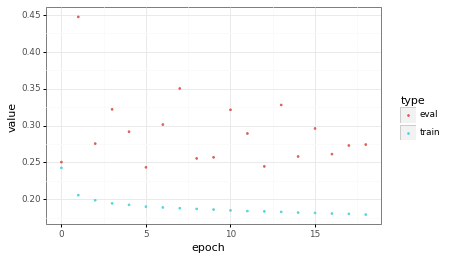

<ggplot: (-9223371888331826232)>

In [9]:
# plot the train_eval loss
train_eval_loss = pd.read_csv('./Metrics_csv/metrics.csv',header=None)
train_eval_loss.columns = ['epoch','type','value']

# plot
plotnine.options.figure_size = (7, 4)
plotnine.options.dpi = 100

(ggplot(train_eval_loss,aes(x='epoch',y='value',color='type')) +
 geom_point(size=0.5) +
 theme_bw()
 )

In [10]:
# load model
best_model = glob.glob('./Saved_models/best_model*')
best_model = sorted(best_model)[-1]

longest_trained_model = glob.glob('./Saved_models/progress_model*')
longest_trained_model = sorted(longest_trained_model)[-1]

In [14]:
# plot the prediction images
eval_imgs = glob.glob('Sample_npy/*')

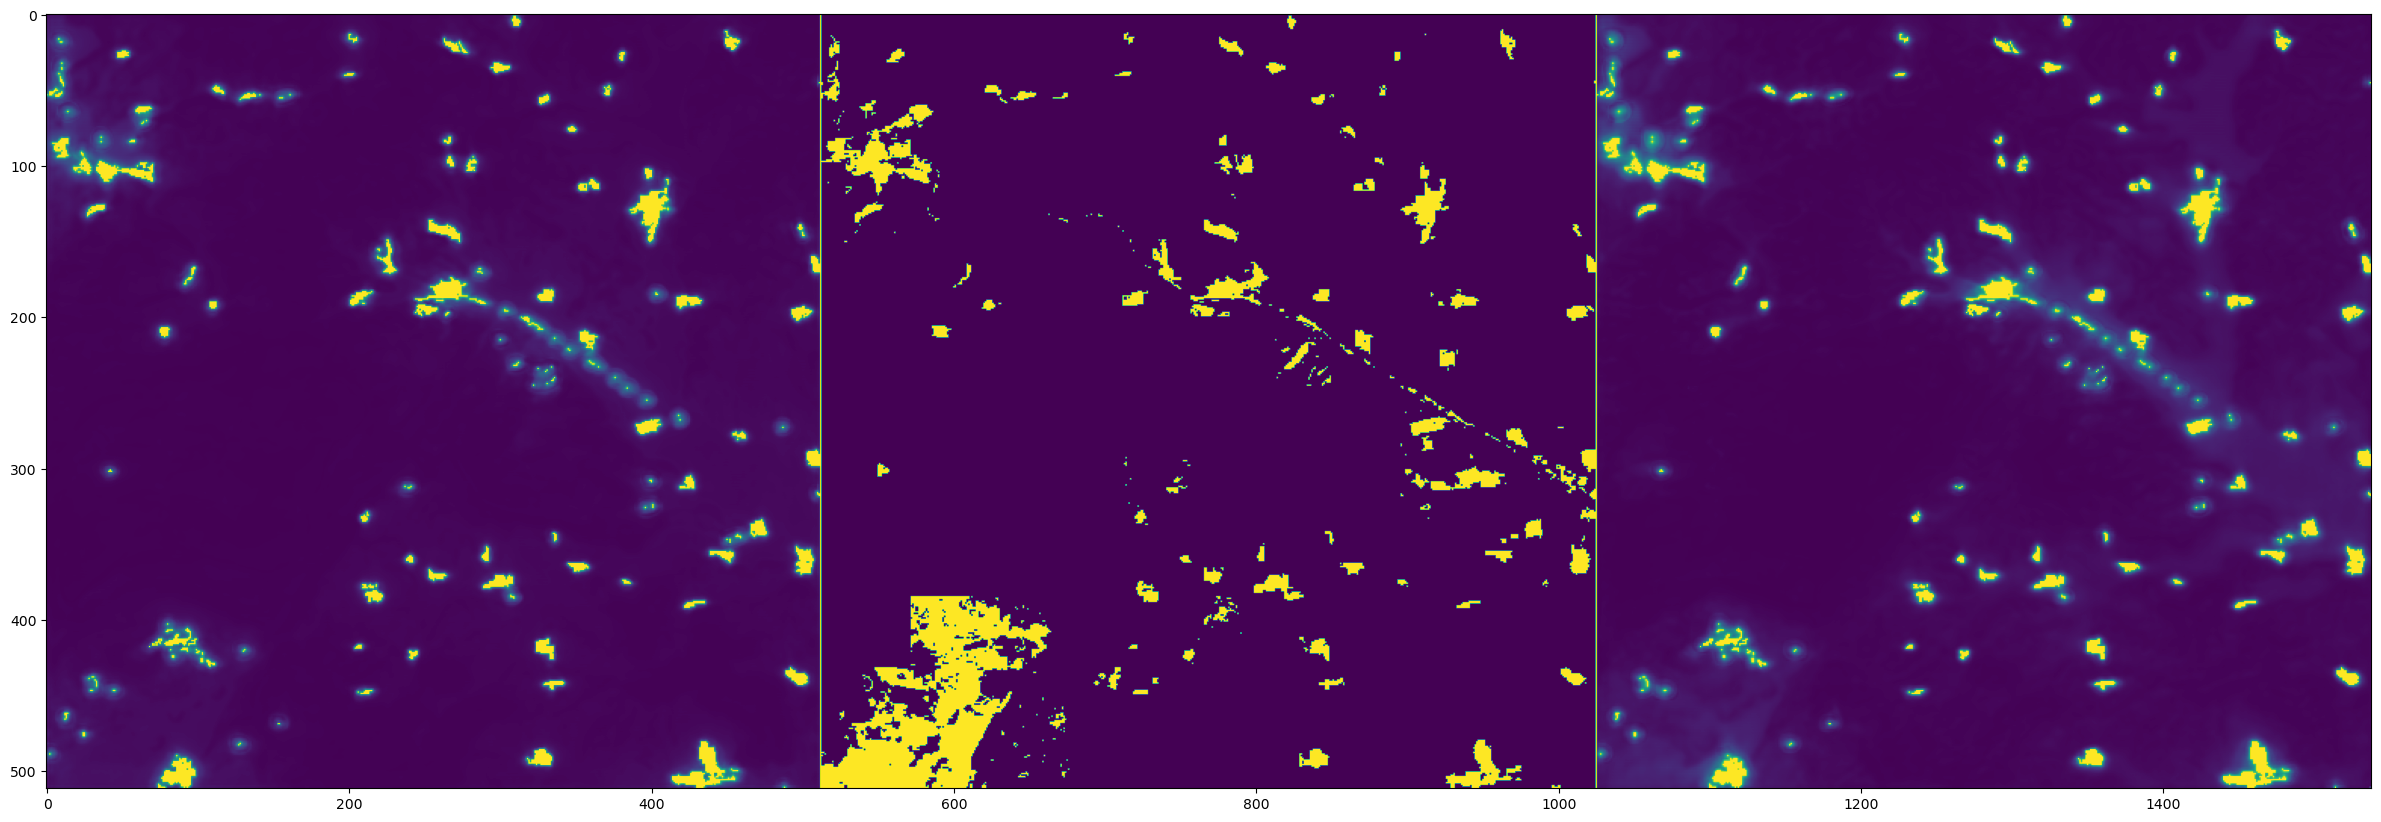

In [29]:
rand_idx = np.random.randint(EVAL_SIZE)
one_img = [i for i in eval_imgs if 'eval' in i][rand_idx]
one_img = np.load(one_img,allow_pickle=True) 

x_img = torch.FloatTensor(one_img[0]).unsqueeze(0).to(dev)
y_img = one_img[1]

# pred with the best model
m.load_state_dict(torch.load(best_model,map_location=torch.device(dev)))
pred_img_best = m(x_img).cpu().detach().numpy()[0,0,:,:]

# pred with the longest trained model
m.load_state_dict(torch.load(longest_trained_model,map_location=torch.device(dev)))
pred_img_longest = m(x_img).cpu().detach().numpy()[0,0,:,:]

true_img = y_img.squeeze(0)

concat_img = np.concatenate((pred_img_best,np.ones((KERNEL_SIZE,1)),true_img,np.ones((KERNEL_SIZE,1)),pred_img_longest),1)


plt.figure(figsize=(30,90))
plt.imshow(concat_img)